In [267]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, asarray
import numpy.random as random

In [268]:
#kalman filter from scratch
class filter_box():
    def __init__(self, dim_state, dim_meas, F, B, H, U, R = None, Q = None):
        assert F.shape == (dim_state, dim_state)
        assert B.shape[0] == dim_state
        assert H.shape == (dim_meas, dim_state)
        
        self.R = R if(R is not None) else np.eye(dim_meas)
        assert R.shape == (dim_meas, dim_meas)
            
        self.Q = Q if(Q is not None) else np.eye(dim_state)
        assert Q.shape == (dim_state, dim_state)
        
        self.F = F
        self.B = B
        self.H = H
        self.U = U
        self.dim_state = dim_state
        self.dim_meas = dim_meas
        
    def initialize(self, X = None, P = None):
        dim_state = self.dim_state
        self.X = X if(X is not None) else np.zeros((dim_state,1))
        self.P = P if(P is not None) else np.eye(dim_state)
            
    def step(self, Y):
        dim_state = self.dim_state
        dim_meas = self.dim_meas
        Y = np.array(Y).reshape(dim_meas, 1)
        X = self.X
        P = self.P
        F = self.F
        B = self.B
        U = self.U
        P = self.P
        Q = self.Q
        R = self.R
        
        X = np.dot(F, X) + np.dot(B, U)
        P = np.dot(F, np.dot(P, F.T)) + Q
        
        V = Y - np.dot(H,X) ### innovation process
        S = np.dot(H, np.dot(P,H.T)) + R  ### measure predictive cov
        K = np.dot(P,np.dot(H.T,np.linalg.inv(S) ))

        self.X = X + np.dot(K,V)
        self.P = P - np.dot(K,np.dot(S,K.T))
        
        return self.X

            
     

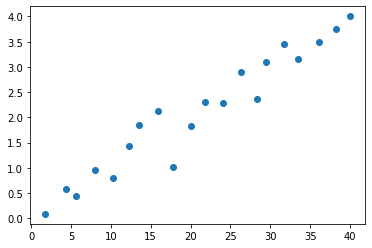

In [269]:
#2-D position sensor simulator
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

    
pos, vel = (0, 0 ), (2, 0.2)
sensor = PosSensor(pos, vel, noise_std=0.35)
ps = np.array([sensor.read() for _ in range(20)])
plt.plot(ps[:, 0], ps[:, 1], 'o')

In [270]:
## Define the state for the simulation experiment
dt = 1
F =         np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])
Q = np.array([[0., 0.001, 0. , 0. ],
              [0.001, 0.001 ,0. ,   0.   ],
              [0.   , 0.   , 0.  ,  0.001],
              [0.   , 0.  ,  0.001 ,0.001]])
B  = np.zeros((4, 1))
U = 0
H = np.array([[1/0.3048, 0, 0,        0],
              [0,        0, 1/0.3048, 0]])
R = np.array([[1 , 0],
              [0, 1]])*(0.35**2)
Xinit = np.array([[0, 0, 0, 0]]).T
Pinit = np.eye(4) * 500

kf = filter_box(4, 2, F, B, H, U, R, Q)
kf.initialize(Xinit, Pinit)


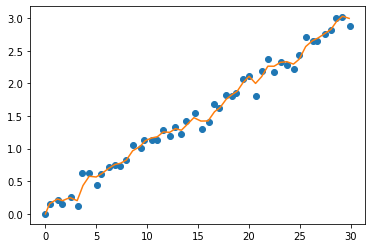

In [271]:
#perform the simulation using the kalman filter we developed
N = 50
sensor = PosSensor((0, 0), (2, .2), noise_std=0.35)

meas = []
est = []
for i in range(N):
    if i==0 : 
        Y = [0, 0]
    else: Y = sensor.read()
    meas.append(Y)

    k_est = kf.step(Y)

    est.append([k_est[0], k_est[2]])
    
meas = np.array(meas)
est = np.array(est)
plt.plot(0.3048*meas[:, 0],0.3048* meas[:, 1], 'o')
plt.plot(est[:, 0], est[:, 1] )
# print(meas*0.3048)
    

In [ ]:
Train on rails example - 

In [272]:
from filterpy.common import Saver
from filterpy.kalman import KalmanFilter

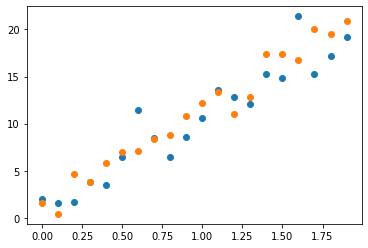

In [327]:
##single sensor simulators for train example
random.seed(1123)
class GPS1_D():
    def __init__(self, inpos = 0, invel = 0, noise_std = 1, dt =1):
        self.vel = invel
        self.pos = inpos
        self.noise_std = noise_std
        
    def read(self):
        self.pos = self.pos + self.vel*dt
        
        return [self.pos + randn()*self.noise_std]
class Wheel():
    def __init__(self, inpos = 0, invel = 0, noise_std = 1, dt =1):
        self.vel = invel
        self.pos = inpos
        self.noise_std = noise_std
        
    def read(self):
        self.pos = self.pos + self.vel*dt
        
        return [self.pos/2 + randn()*self.noise_std]
pos = 0
dt = 0.1
vel = 10
test = Wheel(pos, vel, 1, dt)
test2 = GPS1_D(pos, vel, 1, dt)
ps = np.array([test.read() for _ in range(20)])
ps2 = np.array([test2.read() for _ in range(20)])
time = np.array([x*dt for x in range(20)])


plt.plot( time, ps*2, 'o')
plt.plot(time, ps2, 'o')

Text(0, 0.5, 'Position')

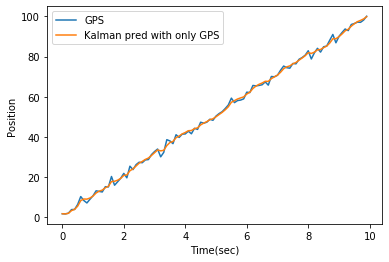

In [352]:
#train on rails - prediction with only GPS sensor
from numpy import array, asarray
import numpy.random as random
random.seed(1123)
R_std = 1.5   # ps_sigma
Q_std = 0.1414
dt = 0.1
def tracker1():
    tracker = KalmanFilter(dim_x=2, dim_z=1)
    dt = 1.0   # time step

    tracker.F = array([[1, dt],
                          [0,  1]])
    tracker.u = 0.
    tracker.H = array([[1, 0]])

    tracker.R = np.eye(1) * (R_std**2)
    tracker.Q *=  array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * (Q_std**2)
    tracker.x = np.array([[0, 0]]).T
    tracker.P = np.eye(2) * 500.
    return tracker

# simulate robot movement
N = 100
sensor = GPS1_D(0, 10, noise_std=R_std, dt = dt)

zs = np.array([sensor.read() for _ in range(N)])
# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

    
#plot results
# zs *= .3048 # convert to meters
# print(mu.shape)
time = [x*dt for x in range(N)]
plt.plot(time, zs, label = 'GPS')
plt.plot(time, mu[:, 0], label ='Kalman pred with only GPS')
plt.legend(loc=2)
# plt.xlim(0, 20);
plt.xlabel('Time(sec)')
plt.ylabel('Position')

Text(0, 0.5, 'Position')

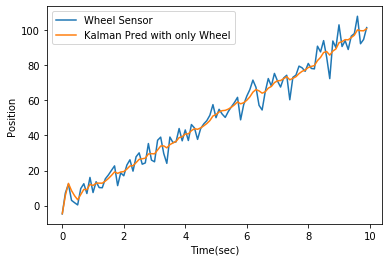

In [355]:
#train on rail - prediction using only Wheel sensor
random.seed(1120)
R_std = 3   #wheel sigma
Q_std = 0.1414
dt = 0.1
def tracker1():
    tracker = KalmanFilter(dim_x=2, dim_z=1)
    dt = 1.0   # time step

    tracker.F = array([[1, dt],
                          [0,  1]])
    tracker.u = 0.
    tracker.H = array([[0.5, 0]])

    tracker.R = np.eye(1) * (R_std**2)
    tracker.Q *=  array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * (Q_std**2)
    tracker.x = np.array([[0, 0]]).T
    tracker.P = np.eye(2) * 500.
    return tracker

# simulate robot movement
N = 100
sensor = Wheel(0, 10, noise_std=R_std, dt = dt)

zs = np.array([sensor.read() for _ in range(N)])

# run filter
tracker = tracker1()
mu, cov, _, _ = tracker.batch_filter(zs)

    
#plot results
# zs *= .3048 # convert to meters
# print(mu.shape)
time = [x*dt for x in range(N)]
plt.plot(time, zs*2, label = 'Wheel Sensor')
plt.plot(time, mu[:, 0], label ='Kalman Pred with only Wheel')
plt.legend(loc =2)
plt.xlabel('Time(sec)')
plt.ylabel('Position')

Text(0, 0.5, 'Position')

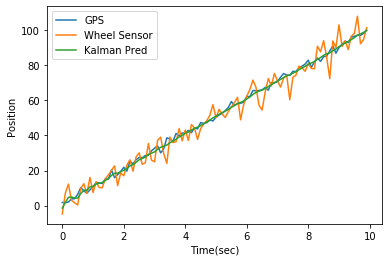

In [357]:
#train on rails - prediction using fused sensor model
random.seed(1123)
from numpy import array, asarray
import numpy.random as random

dt = 0.1

def fused_tracker(wheel_sigma, ps_sigma):
    
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [0.5, 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0, 0] = wheel_sigma**2
    kf.R[1, 1] = ps_sigma**2 
    return kf


ps_sigma = 1.5
wheel_sigma = 3
tracker = fused_tracker(wheel_sigma, ps_sigma)


gps = GPS1_D(0, 10, ps_sigma, dt)

wheel  = Wheel(0, 10, wheel_sigma, dt)

meas1 = array([gps.read() for _ in range(N)])
random.seed(1120)
meas2 = array([wheel.read() for _ in range(N)])

meas = np.concatenate((meas1, meas2), axis = 1)
preds= []
# print(meas.shape)
for i in range(N):
    tracker.predict()
    tracker.update(meas[i, :])
    preds.append(tracker.x[0, :])

# mu, cov, _, _ = tracker.batch_filter(meas)
time = [x*dt for x in range(N)]
plt.plot(time, meas[:, 0], label = 'GPS')
plt.plot(time, meas[:, 1]*2, label = 'Wheel Sensor')
plt.plot(time, preds, label ='Kalman Pred')
plt.legend()
    
plt.xlabel('Time(sec)')
plt.ylabel('Position')

